In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%tensorflow_version 2.x
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from scipy.special import fresnel as _fresnel
from scipy.spatial import KDTree
import pandas as pd
from functools import partial
import typing
from ipywidgets import interact
from pathlib import Path

def fresnel(*args):
    return list(reversed(_fresnel(*args)))

DATA_DIR = Path("/content/drive/My Drive/SH/report/data")

The clothoid is given by the Fresnel integrals
$$S(u) = \int_0^u{\sin\frac{\pi s^2}{2} \ ds}$$
and
$$C(u) = \int_0^u{\cos\frac{\pi s^2}{2} \ ds}$$
as the parametric equations $x(t)=C(t)$ and $y(t)=S(t)$.

The derivative at a specific point $(x(t), y(t))$ is hence
$$
\frac{dy}{dx} = \frac{\sin\frac{\pi t^2}{2}}{\cos\frac{\pi t^2}{2}} = \tan \frac{\pi t^2}{2},
$$
so the angle $\theta$ given $t$ is
$$
\theta(t) = \arctan \left( \tan \frac{\pi t^2}{2} \right)
= \frac{\pi t^2}{2}.
$$

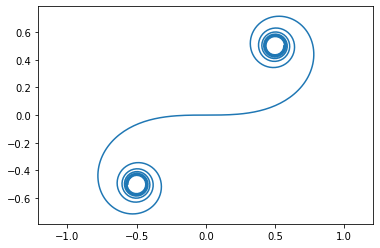

In [40]:
# Plot Euler spiral and save data for plotting in report using pgfplots
x, y = fresnel(np.linspace(-5, 5, 500))
plt.axis('equal')
plt.plot(x, y)

with (DATA_DIR / "clothoid.dat").open("w") as f:
    for xy in zip(x, y):
        f.write("\t".join(map(str, xy)) + "\n")

points:
(0.0, 0.0)
(0.6426319002419629, 0.15645360764497362)
(0.7678990298634281, 0.5235679855547407)
angle at t2 (°):
106.23101915253352
vector of gradient at t2:
(0.7678990298634281, 0.5235679855547407) + -3.4350800416021467*lambda
x-intercept of gradient:
0.9203170169885678


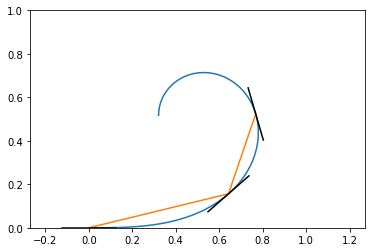

In [41]:
tmax = np.sqrt(3)
#tmax = 2
t_samples = np.linspace(0, tmax, 1000)
t1, t2 = 0.6768535219958538, 1.086436678895909

def get_angle_at(t):
    return np.pi * t**2 / 2
def dy_dx(t):
    return np.tan(get_angle_at(t))

def gradient_vector_at(t):
    xs, ys = fresnel(t)
    dys = dy_dx(t)
    dxs = np.ones_like(ys)
    vecs = np.stack((dxs, dys), axis=-1)
    vecs /= np.linalg.norm(vecs, axis=-1, keepdims=True) * 8
    xy = np.stack((xs, ys), axis=-1)
    return np.stack((xy - vecs, xy + vecs), axis=-2)

CLOTHOID_CACHE = dict()

def draw_clothoid_with_points(ts, tmax=tmax, samples=100):
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    # Plot clothoid
    if (tmax, samples) not in CLOTHOID_CACHE:
        CLOTHOID_CACHE[(tmax, samples)] = fresnel(np.linspace(0, tmax, samples))
    plt.plot(*CLOTHOID_CACHE[(tmax, samples)])
    
    # Plot ts
    plt.plot(*fresnel(ts))

    # Plot gradients at ts
    for data in gradient_vector_at(ts):
        x, y = data.T
        plt.plot(x, y, c="k")

ts = np.array([0, t1, t2])

print("points:")
print("\n".join(map(str, zip(*fresnel(ts)))))

print("angle at t2 (°):")
print(np.degrees(get_angle_at(t2)))
print("vector of gradient at t2:")
p2 = tuple(fresnel(t2))
gradient = dy_dx(t2)
print(f"{p2} + {gradient}*lambda")
print("x-intercept of gradient:")
l = -(p2[1] / gradient)
print(p2[0] + l)


with (DATA_DIR / "clothoid_small.dat").open("w") as f:
    for xy in zip(*fresnel(np.linspace(0, tmax, 200))):
        f.write("\t".join(map(str, xy)) + "\n")


draw_clothoid_with_points(ts)

In [0]:
def angle_between(v1, v2):
    v1 /= np.linalg.norm(v1, axis=-1, keepdims=True)
    v2 /= np.linalg.norm(v2, axis=-1, keepdims=True)
    v1 = np.expand_dims(v1, axis=-2)
    v2 = np.expand_dims(v2, axis=-1)
    return np.arccos(np.matmul(v1, v2)).reshape(v1.shape[:-2])

def calculate_clothoid_parameters(t1, t2):
    ts = np.stack((np.zeros_like(t1), t1, t2), axis=0)
    #draw_clothoid_with_points(ts)

    p0, p1, p2 = np.stack(fresnel(ts), axis=-1)

    gamma1 = angle_between(p1-p0, p1-p2)
    gamma2 = angle_between(p2-p0, p2-p1)
    theta = get_angle_at(t2) # angle at end
    omega = np.arctan(p1[..., 1] / p1[..., 0])
    beta = omega + np.pi - gamma1 - gamma2
    alpha = theta - beta

    return gamma1, gamma2, alpha, beta, t1, t2

t1, t2 = np.stack(np.meshgrid(t_samples, t_samples), axis=-1).reshape(-1, 2).T
cond = (t1 < t2) & (t1 > 0)
t1 = t1[cond]
t2 = t2[cond]
gamma1, gamma2, *values = calculate_clothoid_parameters(t1, t2)
indices = np.array((gamma1, gamma2)).T
values = np.array(values).T
tree = KDTree(indices)

def lookup_parameters(gamma1, gamma2, k=1):
    d, i = tree.query(np.stack([gamma1, gamma2], axis=-1), k)
    return values[i]

In [43]:
alpha, beta, t1, t2 = lookup_parameters(np.radians(90), np.radians(80), k=1).T
ts = np.array([np.zeros_like(t1), t1, t2])

def update(gamma1=90., gamma2=70.):
    alpha, beta, t1, t2 = lookup_parameters(np.radians(gamma1), np.radians(gamma2), k=1).T
    ts = np.array([np.zeros_like(t1), t1, t2, np.zeros_like(t1)])
    draw_clothoid_with_points(ts)
interact(update, gamma1=(1, 180, 1), gamma2=(1, 180, 1))
pass

interactive(children=(IntSlider(value=90, description='gamma1', max=180, min=1), IntSlider(value=70, descripti…

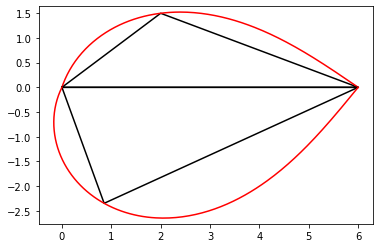

In [63]:
def pad(X):
        return np.hstack([X, np.ones((X.shape[0], 1))])

def unpad(X):
    return X[:,:-1]

def compute_transformation_matrix(I, O):
    A, *_ = np.linalg.lstsq(pad(I), pad(O), rcond=None)
    return A

def affine_transform(I, A):
    return unpad(pad(I) @ A)

def plot_clothoid_given_points(p0, p1, p2, c="k"):
    p0, p1, p2 = np.array([p0, p1, p2], dtype=np.float32)
    plt.axis("equal")
    plt.plot(*list(zip(p2, p1, p0, p2)), c=c)

    gamma1 = angle_between(p1-p2, p1-p0)
    gamma2 = angle_between(p2-p1, p2-p0)

    alpha, beta, t1, t2 = lookup_parameters(gamma1, gamma2)

    c0, c1, c2 = map(np.array, zip(*fresnel([np.zeros_like(t1), t1, t2])))

    P = np.array([p0, p1, p2])
    C = np.array([c0, c1, c2])

    A = compute_transformation_matrix(C, P)
    plt.plot(*affine_transform(np.array(fresnel(np.linspace(0, t2, 200))).T, A).T, c="r")


p2 = (0, 0) # current output
p1 = (2., 1.5) # sample
p0 = (6, 0) # goal/subgoal

plot_clothoid_given_points(p0, p1, p2)

r = np.linalg.norm(p1)
angle = np.radians(-70)
p1_2 = np.array((np.cos(angle), np.sin(angle))) * r
plot_clothoid_given_points(p0, p1_2, p2)

In [57]:
def save_clothoid_given_points(p0, p1, p2, filename: str):
    p0, p1, p2 = np.array([p0, p1, p2], dtype=np.float32)
    gamma1 = angle_between(p1-p2, p1-p0)
    gamma2 = angle_between(p2-p1, p2-p0)

    alpha, beta, t1, t2 = lookup_parameters(gamma1, gamma2)

    c0, c1, c2 = map(np.array, zip(*fresnel([np.zeros_like(t1), t1, t2])))

    P = np.array([p0, p1, p2])
    C = np.array([c0, c1, c2])

    A = compute_transformation_matrix(C, P)
    with (DATA_DIR / filename).open("w") as f:
        for xy in affine_transform(np.array(fresnel(np.linspace(0, t2, 200))).T, A):
            f.write("\t".join(map(str, xy)) + "\n")
    
    print("File:", filename)
    print("  p0:", tuple(p0))
    print("  p1:", tuple(p1))
    print("  p2:", tuple(p2))
    print("  t1:", t1)
    print("  t2:", t2)
    print("  gamma1:", gamma1, f"({np.degrees(gamma1)}°)")
    print("  gamma2:", gamma2, f"({np.degrees(gamma2)}°)")
    print("  alpha: ", alpha, f"({np.degrees(alpha)}°)")
    print("  beta:  ", beta, f"({np.degrees(beta)}°)")
    print("  theta: ", alpha+beta, f"({np.degrees(alpha+beta)}°)")

save_clothoid_given_points(p0, p1, p2, filename="clothoid_segment.dat")

File: clothoid_segment.dat
  p0: (6.0, 0.0)
  p1: (2.0, 1.5)
  p2: (0.0, 0.0)
  t1: 0.6779097755349659
  t2: 1.08534915469281
  gamma1: 2.1393209 (122.57405090332031°)
  gamma2: 0.6435011 (36.869895935058594°)
  alpha:  1.2530639654592775 (71.79527668074337°)
  beta:   0.5973070703184729 (34.22317420257238°)
  theta:  1.8503710357777503 (106.01845088331575°)


File: clothoid_for_points_1.dat
  p0: (7.0, 0.0)
  p1: (0.5, 0.8660254)
  p2: (0.0, 0.0)
  t1: 0.9570490948728931
  t2: 1.092284293061454
  gamma1: 1.9619405 (112.41090393066406°)
  gamma2: 1.0471976 (60.0°)
  alpha:  1.26968454293453 (72.74756562314553°)
  beta:   0.604408956285093 (34.6300822950429°)
  theta:  1.874093499219623 (107.37764791818843°)
File: clothoid_for_points_2.dat
  p0: (7.0, 0.0)
  p1: (-0.9396926, 0.34202015)
  p2: (0.0, 0.0)
  t1: 1.5135939489565864
  t2: 1.6158872398940876
  gamma1: 0.30601528 (17.533382415771484°)
  gamma2: 2.7925267 (159.99998474121094°)
  alpha:  3.0474034862142556 (174.6033582335304°)
  beta:   1.0540895640909742 (60.39488325119751°)
  theta:  4.10149305030523 (234.9982414847279°)


(-2.0, 7.0)

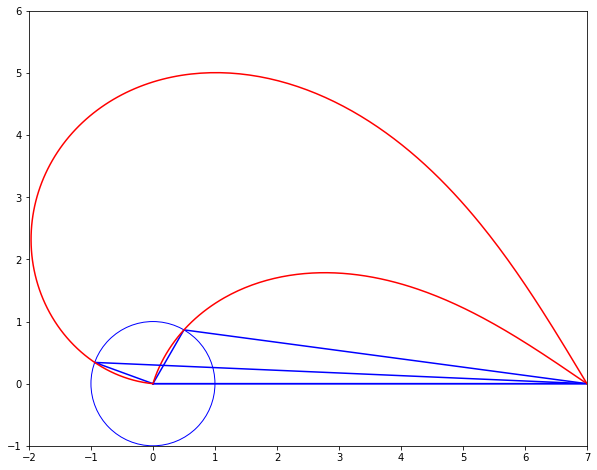

In [78]:
fig = plt.figure(figsize=(10,8))

unit_vector_in_direction = lambda x: np.array([1, np.tan(np.radians(x))]) / np.linalg.norm([1, np.tan(np.radians(x))])
y1 = unit_vector_in_direction(60)
goal = 7., 0

points = np.array([goal,
                   y1,
                   [0, 0]])
save_clothoid_given_points(*points, filename="clothoid_for_points_1.dat")
plot_clothoid_given_points(*points, c="b")

points = np.array([goal,
                   unit_vector_in_direction(20) * np.array([-1, 1]),
                   [0, 0]])
save_clothoid_given_points(*points, filename="clothoid_for_points_2.dat")
plot_clothoid_given_points(*points, c="b")



ax = fig.gca()
circle1 = plt.Circle((0, 0), 1, color='b', fill=False)
circle2 = plt.Circle(y1, 1, color='g', fill=False)
ax.add_artist(circle1)
ax.set_ylim(-1, 6)
ax.set_xlim(-2, 7)

File: clothoid_for_points_1.dat
  p0: (7.0, 0.0)
  p1: (0.5, 0.8660254)
  p2: (0.0, 0.0)
  t1: 0.9570490948728931
  t2: 1.092284293061454
  gamma1: 1.9619405 (112.41090393066406°)
  gamma2: 1.0471976 (60.0°)
  alpha:  1.26968454293453 (72.74756562314553°)
  beta:   0.604408956285093 (34.6300822950429°)
  theta:  1.874093499219623 (107.37764791818843°)
File: clothoid_for_points_3.dat
  p0: (7.0, 0.0)
  p1: (0.5, 1.8660254)
  p2: (0.0, 0.0)
  t1: 1.0264004785593346
  t2: 1.2951370903442956
  gamma1: 1.5530331 (88.98223876953125°)
  gamma2: 1.3089969 (74.99999237060547°)
  alpha:  1.818390581397067 (104.18610582039193°)
  beta:   0.8164318912812971 (46.778101630302°)
  theta:  2.6348224726783642 (150.96420745069392°)
File: clothoid_for_points_4.dat
  p0: (7.0, 0.0)
  p1: (-0.26604444, 1.508813)
  p2: (0.0, 0.0)
  t1: 1.2015127223675994
  t2: 1.40263173505828
  gamma1: 1.1915205 (68.26908874511719°)
  gamma2: 1.7453293 (99.99999237060547°)
  alpha:  2.1677090328112105 (124.20057879246805°)

(-2.0, 7.0)

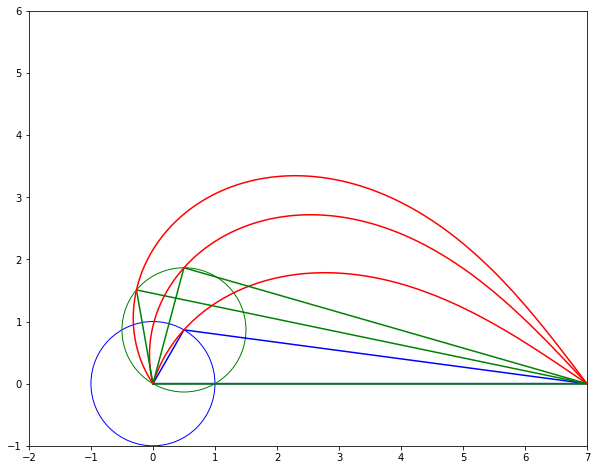

In [77]:
fig = plt.figure(figsize=(10,8))
ax = fig.gca()


unit_vector_in_direction = lambda x: np.array([1, np.tan(np.radians(x))]) / np.linalg.norm([1, np.tan(np.radians(x))])
y1 = unit_vector_in_direction(60)
goal = 7., 0

points = np.array([goal,
                   y1,
                   [0, 0]])
save_clothoid_given_points(*points, filename="clothoid_for_points_1.dat")
plot_clothoid_given_points(*points, c="b")

points = np.array([goal,
                   y1 + unit_vector_in_direction(90),
                   [0, 0]])
save_clothoid_given_points(*points, filename="clothoid_for_points_3.dat")
plot_clothoid_given_points(*points, c="g")

points = np.array([goal,
                   y1 + unit_vector_in_direction(40) * np.array([-1, 1]),
                   [0, 0]])
save_clothoid_given_points(*points, filename="clothoid_for_points_4.dat")
plot_clothoid_given_points(*points, c="g")

circle1 = plt.Circle((0, 0), 1, color='b', fill=False)
circle2 = plt.Circle(y1, 1, color='g', fill=False)
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.set_ylim(-1, 6)
ax.set_xlim(-2, 7)